# Multivariate Linear Models

In [1]:
import  warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
%matplotlib inline

In [3]:
sns.set()

## Spurious Association

### 5.1

In [4]:
d = pd.read_csv('Data/WaffleDivorce.csv', sep=';')
d["MedianAgeMarriage_s"] = (d["MedianAgeMarriage"] - d["MedianAgeMarriage"].mean())/d["MedianAgeMarriage"].std()

In [5]:
with pm.Model() as m5_1:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bA * d["MedianAgeMarriage_s"])
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d["Divorce"])
    trace_5_1 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:15<00:00, 1458.29draws/s]


### 5.2

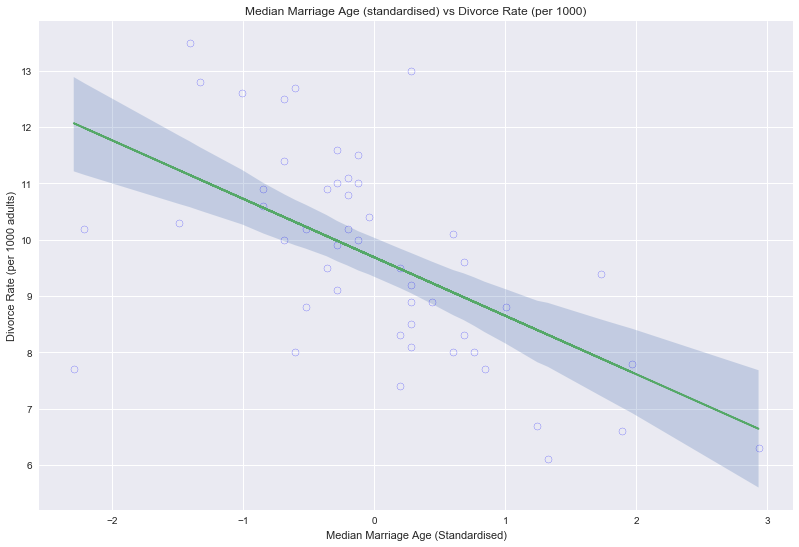

In [6]:
mu_mean = trace_5_1["mu"]
mu_pi = pm.hpd(mu_mean, alpha=0.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d["MedianAgeMarriage_s"], d["Divorce"], "o", mew=0.2, mec="b", mfc="None")
ax.plot(d["MedianAgeMarriage_s"], mu_mean.mean(0))

idx = np.argsort(d["MedianAgeMarriage_s"])
ax.fill_between(d["MedianAgeMarriage_s"][idx], mu_pi[:,0][idx], mu_pi[:,1][idx], alpha=0.25)

ax.set_title("Median Marriage Age (standardised) vs Divorce Rate (per 1000)")
ax.set_xlabel("Median Marriage Age (Standardised)")
ax.set_ylabel("Divorce Rate (per 1000 adults)");

### 5.3

In [7]:
d["Marriage_s"] = (d["Marriage"] - d["Marriage"].mean())/d["Marriage"].std()

In [8]:
with pm.Model() as m5_2:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bA * d["Marriage_s"])
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d["Divorce"])
    trace_5_2 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bA, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:13<00:00, 1648.17draws/s]


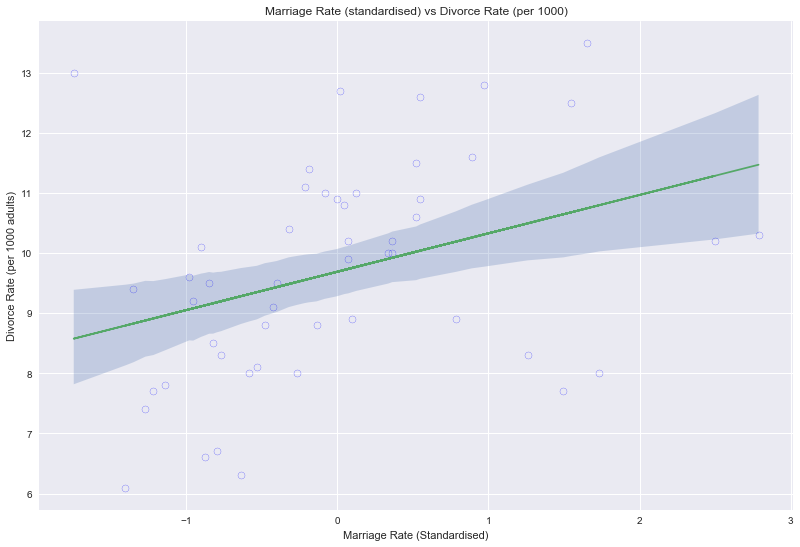

In [9]:
mu_mean = trace_5_2["mu"]
mu_pi = pm.hpd(mu_mean, alpha=0.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.plot(d["Marriage_s"], d["Divorce"], "o", mew=0.2, mec="b", mfc="None")
ax.plot(d["Marriage_s"], mu_mean.mean(0))

idx = np.argsort(d["Marriage_s"])
ax.fill_between(d["Marriage_s"][idx], mu_pi[:,0][idx], mu_pi[:,1][idx], alpha=0.25)

ax.set_title("Marriage Rate (standardised) vs Divorce Rate (per 1000)")
ax.set_xlabel("Marriage Rate (Standardised)")
ax.set_ylabel("Divorce Rate (per 1000 adults)");

### 5.4

In [10]:
with pm.Model() as m5_3:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bA = pm.Normal("bA", mu=0, sd=1)    
    bR = pm.Normal("bR", mu=0, sd=1)    
    a = pm.Normal("a", mu=10, sd=10)
    mu = pm.Deterministic("mu", a + bR * d["Marriage_s"]) + bA * d["MedianAgeMarriage_s"]
    Divorce = pm.Normal("Divorce", mu=mu, sd=sigma, observed=d["Divorce"])
    trace_5_3 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bR, bA, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:21<00:00, 1005.43draws/s]


In [11]:
pm.summary(trace_5_3, varnames=["a", "bR", "bA", "sigma"], alpha=0.11)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,9.687589,0.215769,0.001335,9.348018,10.035328,16325.572052,0.999964
bR,-0.122881,0.292406,0.002779,-0.589521,0.340949,12614.658136,0.999994
bA,-1.124752,0.293853,0.002708,-1.603674,-0.672641,12251.268432,0.999972
sigma,1.524022,0.164423,0.001328,1.261372,1.770230,16600.807915,0.999950


### 5.5

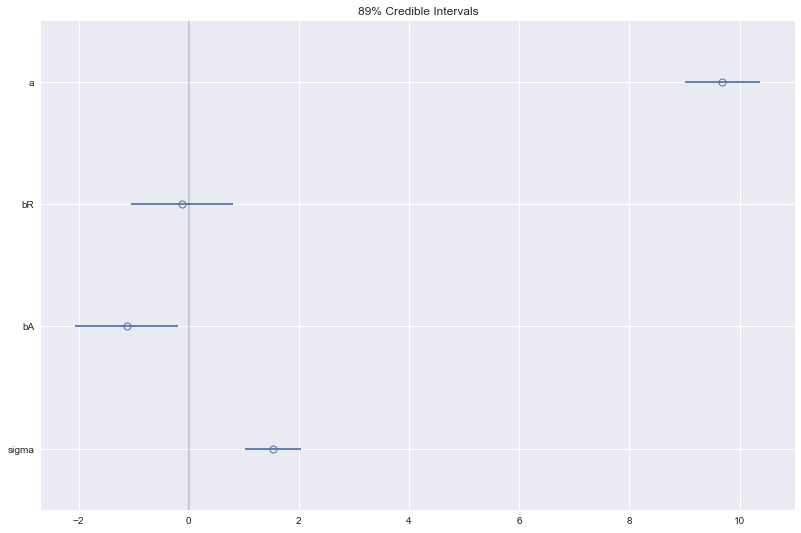

In [12]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
data = pm.summary(trace_5_3, varnames=["a", "bR", "bA", "sigma"], alpha=0.11)
ax.errorbar(data["mean"], data.index, fmt="o", xerr=data["hpd_94.5"] - data["hpd_5.5"], 
            mew=1, mfc="None")
ax.vlines(0, ymin=-1, ymax=4, alpha=0.2);
ax.set_ylim(-0.5, 3.5)
ax.invert_yaxis()
ax.set_title("89% Credible Intervals");

### 5.6

In [13]:
with pm.Model() as m5_4:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    b = pm.Normal("b", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=10)
    mu = pm.Deterministic("mu", a + b * d["MedianAgeMarriage_s"])
    Marriage_s = pm.Normal("Marriage_s", mu=mu, sd=sigma, observed=d["Marriage_s"])
    trace_5_4 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, b, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:17<00:00, 1272.27draws/s]


### 5.7

In [14]:
mu = trace_5_4["mu"].mean(0)
m_resid = d["Marriage_s"] - mu

### 5.8

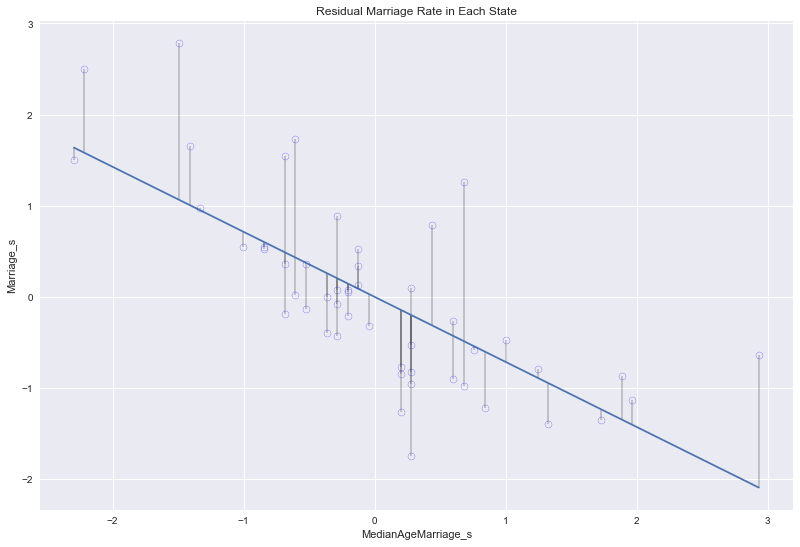

In [15]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
idx = np.argsort(d["MedianAgeMarriage_s"])
ax.plot(d["MedianAgeMarriage_s"][idx], mu[idx])
ax.vlines(d["MedianAgeMarriage_s"], mu, mu + m_resid, alpha=0.2)
ax.plot(d["MedianAgeMarriage_s"], mu + m_resid, "o", mew=0.2, mec="b", mfc="None")
ax.set_title("Residual Marriage Rate in Each State")
ax.set_xlabel("MedianAgeMarriage_s")
ax.set_ylabel("Marriage_s");

### 5.9

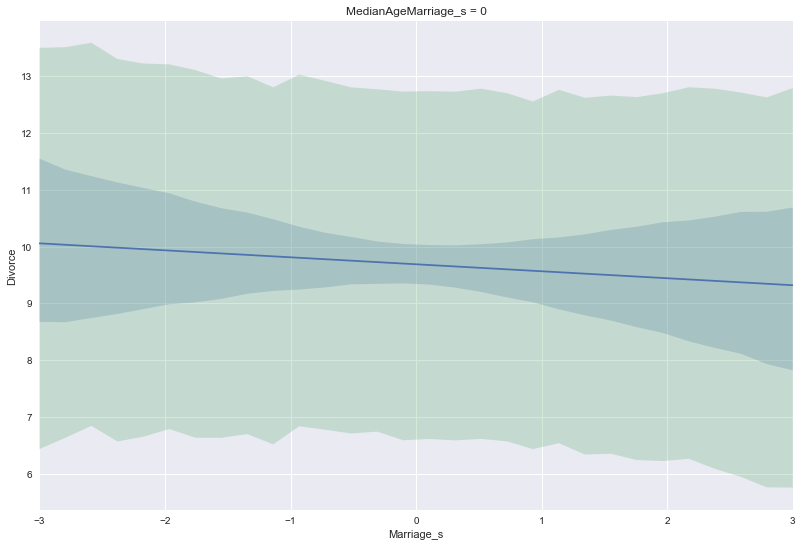

In [16]:
A_avg = d["MedianAgeMarriage_s"].mean()
R_seq = np.linspace(-3, 3, 30)

mu = trace_5_3["a"].reshape(-1, 1) +\
     (trace_5_3["bA"] * A_avg).reshape(-1, 1) +\
     (trace_5_3["bR"].reshape(-1, 1) * R_seq)

sigma = (trace_5_3["sigma"]
         .repeat(30)
         .reshape(-1, 30))

R_sim = stats.norm.rvs(loc=mu, scale=sigma)
mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=.11)
R_pi = pm.hpd(R_sim)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(R_seq, mu_mean)
ax.fill_between(R_seq, mu_pi[:,0], mu_pi[:,1], alpha=0.25)
ax.fill_between(R_seq, R_pi[:,0], R_pi[:,1], alpha=0.25)
ax.set_title("MedianAgeMarriage_s = 0")
ax.set_xlabel("Marriage_s")
ax.set_ylabel("Divorce")
ax.set_xlim(-3, 3);

### 5.10

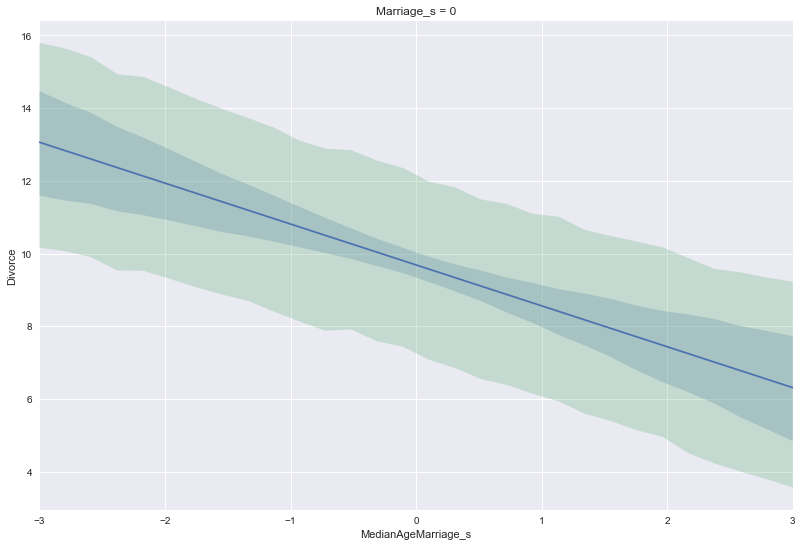

In [17]:
A_seq = np.linspace(-3, 3, 30)
R_avg = d["Marriage_s"].mean()

mu = trace_5_3["a"].reshape(-1, 1) +\
     (trace_5_3["bA"].reshape(-1, 1) * A_seq) +\
     (trace_5_3["bR"] * R_avg).reshape(-1, 1)

sigma = (trace_5_3["sigma"]
         .repeat(30)
         .reshape(-1, 30))

A_sim = stats.norm.rvs(loc=mu, scale=sigma)
mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=.11)
A_pi = pm.hpd(A_sim, alpha=.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(A_seq, mu_mean)
ax.fill_between(A_seq, mu_pi[:,0], mu_pi[:,1], alpha=0.25)
ax.fill_between(A_seq, A_pi[:,0], A_pi[:,1], alpha=0.25)
ax.set_title("Marriage_s = 0")
ax.set_xlabel("MedianAgeMarriage_s")
ax.set_ylabel("Divorce")
ax.set_xlim(-3, 3);

### 5.11

In [18]:
mu = trace_5_3["mu"]

mu_mean = mu.mean(0).reshape(-1, 1)
mu_pi = pm.hpd(mu, alpha=.11)

divorce_sim = pm.sample_ppc(trace_5_3, samples=int(1e4), model=m5_3)['Divorce']
divorce_mean = divorce_sim.mean(0).reshape(-1, 1)
divorce_pi = pm.hpd(divorce_sim, alpha=.11)

100%|██████████| 10000/10000 [00:11<00:00, 870.29it/s]


### 5.12 - 5.13

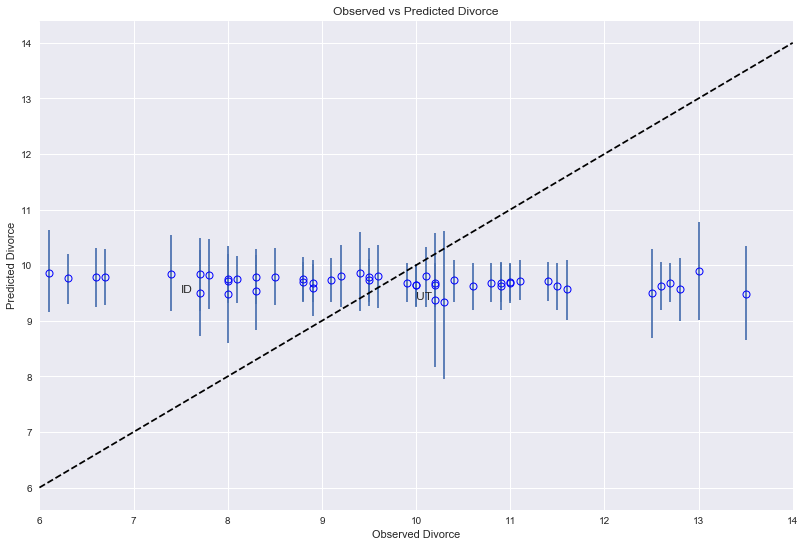

In [19]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.errorbar(x=d["Divorce"], y=mu_mean, fmt="o", yerr=np.abs(mu_mean - mu_pi).T,
           mew=1.0, mec="b", mfc="None");
ax.plot([6, 14], [6, 14], "k--")
ax.set_title("Observed vs Predicted Divorce")
ax.set_xlabel("Observed Divorce")
ax.set_ylabel("Predicted Divorce")
ax.set_xlim(6, 14)

ID = (d.loc[12]["Divorce"], mu_mean[12])
UT = (d.loc[43]["Divorce"], mu_mean[43])
ax.annotate("ID", ID, xytext=(ID[0]-0.2, ID[1]))
ax.annotate("UT", UT, xytext=(UT[0]-0.2, UT[1]));

### 5.14

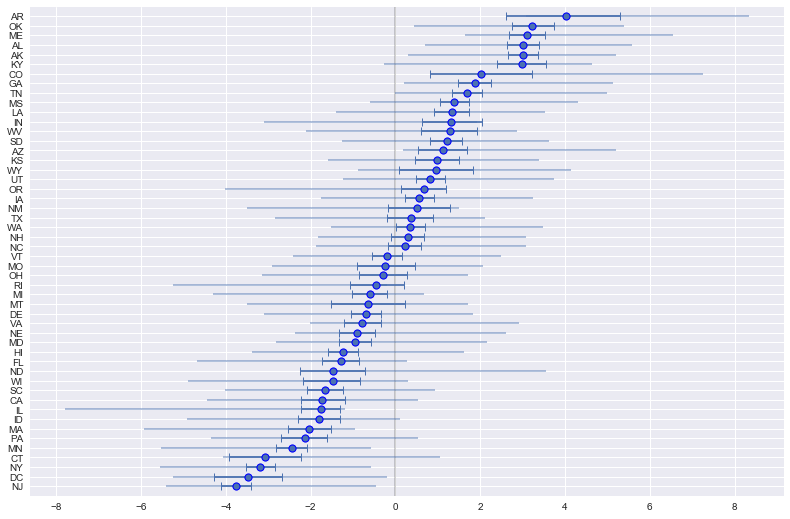

In [20]:
divorce_resid = d["Divorce"] - mu_mean.ravel()
o = np.argsort(divorce_resid)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.vlines(0, -1, len(d), alpha=0.2)
ax.errorbar(divorce_resid[o], d.loc[o]["Loc"], xerr=np.abs(mu_mean-divorce_pi).T,
            fmt="o", mfc="C0", mew=1.0, mec="b", alpha=0.5, ecolor="C0")    
ax.errorbar(divorce_resid[o], d.loc[o]["Loc"], xerr=np.abs(mu_mean-mu_pi).T, 
            fmt="o", capsize=4, mfc="C0", mew=1.0, mec="b", ecolor="C0")
ax.set_ylim(-1, len(d));

### 5.15

In [21]:
N = 100
x_real = stats.norm.rvs(size=N)
x_spur = stats.norm.rvs(loc=x_real)
y = stats.norm.rvs(size=N, loc=x_real)
d = pd.DataFrame({"y": y,
                  "x_real": x_real,
                  "x_spur": x_spur})

## Masked Relationship

### 5.16

In [22]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### 5.17

In [23]:
with pm.Model() as m5_5:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bn = pm.Normal("bn", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bn * d["neocortex.perc"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_5 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, sigma]
Sampling 2 chains:   0%|          | 0/22000 [00:00<?, ?draws/s]


RuntimeError: Chain 1 failed.

### 5.18

In [24]:
d["neocortex.perc"]

0     55.16
1       NaN
2       NaN
3       NaN
4       NaN
5     64.54
6     64.54
7     67.64
8       NaN
9     68.85
10    58.85
11    61.69
12    60.32
13      NaN
14      NaN
15    69.97
16      NaN
17    70.41
18      NaN
19    73.40
20      NaN
21    67.53
22      NaN
23    71.26
24    72.60
25      NaN
26    70.24
27    76.30
28    75.49
Name: neocortex.perc, dtype: float64

### 5.19

In [25]:
dcc = d.dropna()

### 5.20

In [26]:
with pm.Model() as m5_5:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bn = pm.Normal("bn", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bn * dcc["neocortex.perc"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_5 = pm.sample(int(1e4), tune=1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [01:21<00:00, 271.55draws/s]
There were 62 divergences after tuning. Increase `target_accept` or reparameterize.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


### 5.21

In [27]:
pm.summary(trace_5_5, varnames=["a", "bn", "sigma"], alpha=0.11).round(3)

,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.356,0.560,0.006,-0.531,1.230,5831.804,1.0
bn,0.004,0.008,0.000,-0.009,0.017,5844.264,1.0
sigma,0.193,0.039,0.001,0.135,0.250,3792.651,1.0


### 5.22

In [28]:
trace_5_5["bn"].mean() * (76 - 55)

0.09387189702105664

### 5.23

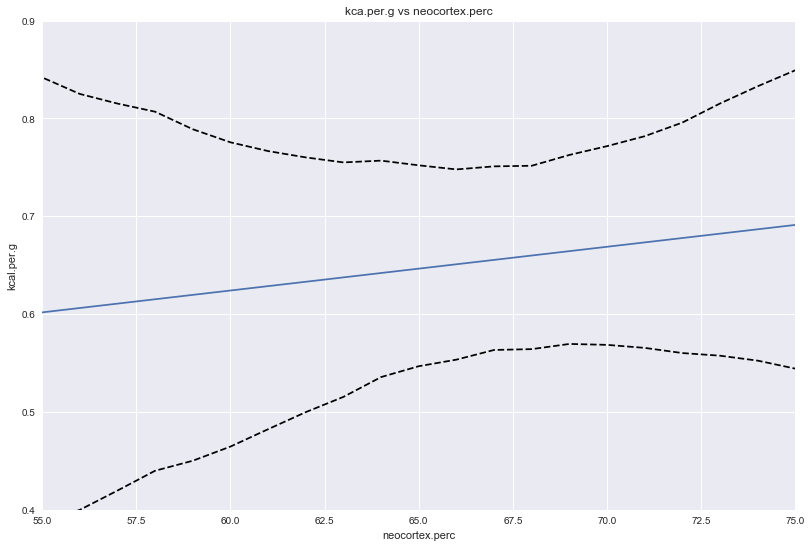

In [29]:
np_seq = np.arange(0, 100)

mu = trace_5_5["a"].reshape(-1, 1) +\
     (trace_5_5["bn"].reshape(-1, 1) * np_seq)

mu_mean = mu.mean(0)
mu_pi = pm.hpd(mu)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(np_seq, mu_mean)
ax.plot(np_seq, mu_pi[:, 0], "k--")
ax.plot(np_seq, mu_pi[:, 1], "k--")
ax.set_xlabel("neocortex.perc")
ax.set_ylabel("kcal.per.g")
ax.set_xlim(55, 75)
ax.set_title("kca.per.g vs neocortex.perc")
ax.set_ylim(0.4, 0.9);

### 5.24

In [30]:
dcc["log_mass"] = np.log(dcc["mass"])

### 5.25

In [31]:
with pm.Model() as m5_6:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bm = pm.Normal("bm", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bm * dcc["log_mass"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_6 = pm.sample(int(1e4), tune=1000)
    
pm.summary(trace_5_6, varnames=["a", "bm", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bm, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:19<00:00, 1150.25draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,0.704849,0.057002,0.000567,0.615243,0.793521,9560.472957,0.999959
bm,-0.031478,0.023888,0.000220,-0.067509,0.007581,9600.263769,0.999963
sigma,0.182582,0.037374,0.000365,0.124710,0.233910,9917.774796,1.000045


### 5.26

In [32]:
with pm.Model() as m5_7:
    sigma = pm.Uniform("sigma", lower=0, upper=1)
    bm = pm.Normal("bm", mu=0, sd=1)    
    bn = pm.Normal("bn", mu=0, sd=1)    
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bm*dcc["log_mass"] + bn*dcc["neocortex.perc"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=dcc["kcal.per.g"])
    trace_5_7 = pm.sample(int(1e4), tune=1000)

pm.summary(trace_5_7, varnames=["a", "bm", "bn", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bn, bm, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [01:58<00:00, 184.88draws/s]
There were 81 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8893484680218253, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,-1.078894,0.586474,0.008071,-2.033556,-0.171651,4543.115416,0.999963
bm,-0.095901,0.027904,0.000370,-0.139557,-0.051596,5389.187815,1.000005
bn,0.027823,0.009117,0.000126,0.013834,0.042769,4480.477139,0.999966
sigma,0.140235,0.029873,0.000407,0.094437,0.180126,4592.627262,1.000218


### 5.27

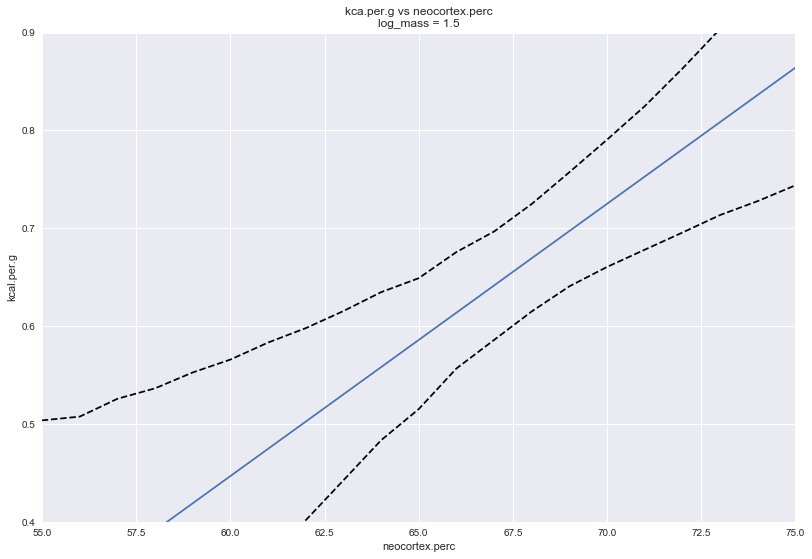

In [33]:
mean_log_mass = dcc["log_mass"].mean()
np_seq = np.arange(0, 100)

mu = trace_5_7["a"].reshape(-1, 1) +\
     (trace_5_7["bm"] * mean_log_mass).reshape(-1, 1) +\
     (trace_5_7["bn"].reshape(-1, 1) * np_seq)

mu_mean = mu.mean(axis=0)
mu_pi = pm.hpd(mu, alpha=.11)

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(np_seq, mu_mean)
ax.plot(np_seq, mu_pi[:, 0], "k--")
ax.plot(np_seq, mu_pi[:, 1], "k--")
ax.set_xlabel("neocortex.perc")
ax.set_ylabel("kcal.per.g")
ax.set_xlim(55, 75)
ax.set_title("kca.per.g vs neocortex.perc\nlog_mass = 1.5")
ax.set_ylim(0.4, 0.9);

### 5.28

In [34]:
N = 100
rho = 0.7
x_pos = stats.norm.rvs(size=N)
x_neg = stats.norm.rvs(loc=rho*x_pos, scale=np.sqrt(1-rho**2))
y = stats.norm.rvs(loc=x_pos-x_neg)
d = pd.DataFrame({"y": y,
                  "x_pos": x_pos,
                  "x_neg": x_neg})

## When adding variables hurts

### 5.29

In [35]:
N = 100
height = stats.norm.rvs(10, 2, N)
leg_prop = stats.uniform.rvs(0.4, 0.5, N)
leg_left = leg_prop*height + stats.norm.rvs(0, 0.02, N)
leg_right = leg_prop*height + stats.norm.rvs(0, 0.02, N)
d = pd.DataFrame({"height": height,
                  "leg_left": leg_left,
                  "leg_right": leg_right})

### 5.30

In [36]:
with pm.Model() as m5_8:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    br = pm.Normal("br", mu=2, sd=10)
    bl = pm.Normal("bl", mu=2, sd=10)
    a = pm.Normal("a", mu=10, sd=100)
    mu = pm.Deterministic("mu", a + bl*d["leg_left"] + br*d["leg_right"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_8 = pm.sample(int(1e4), tune=1000)

pm.summary(trace_5_8, varnames=["a", "bl", "br", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, br, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [43:14<00:00, 10.69draws/s]     
There were 8 divergences after tuning. Increase `target_accept` or reparameterize.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,5.330155,0.519645,0.005481,4.485785,6.149200,10908.763722,1.000512
bl,-2.582033,4.018160,0.051960,-8.915398,3.875466,6300.783009,1.000008
br,3.304208,4.013092,0.051801,-3.180720,9.590979,6316.823865,1.000015
sigma,1.510493,0.111004,0.001050,1.336524,1.686769,11664.217649,0.999956


### 5.31

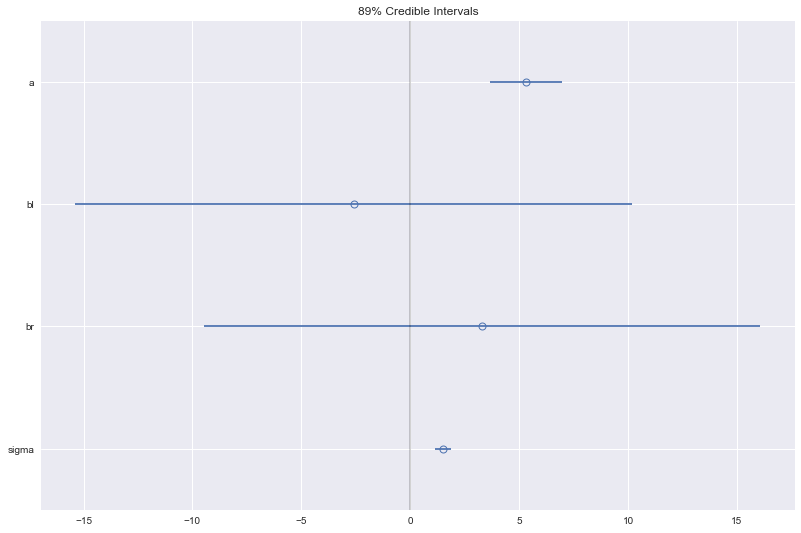

In [37]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
data = pm.summary(trace_5_8, varnames=["a", "bl", "br", "sigma"], alpha=0.11)
ax.errorbar(data["mean"], data.index, fmt="o", xerr=data["hpd_94.5"] - data["hpd_5.5"], 
            mew=1, mfc="None")
ax.vlines(0, ymin=-1, ymax=4, alpha=0.2);
ax.set_ylim(-0.5, 3.5)
ax.invert_yaxis()
ax.set_title("89% Credible Intervals");

### 5.32

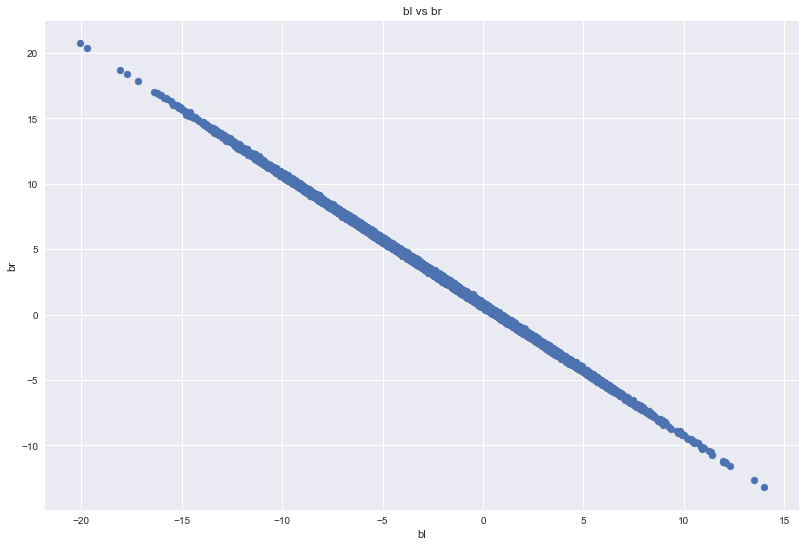

In [38]:
f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
ax.scatter(trace_5_8["bl"], trace_5_8["br"])
ax.set_xlabel("bl")
ax.set_ylabel("br")
ax.set_title("bl vs br");

### 5.33

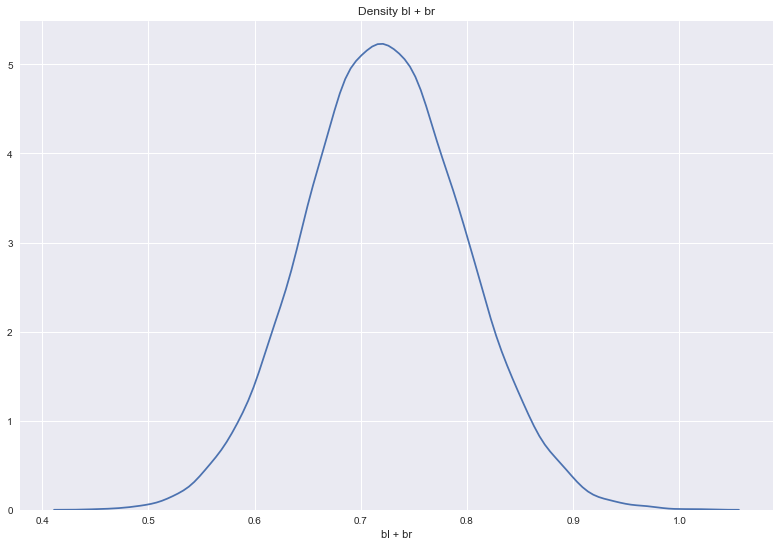

In [39]:
sum_blbr = trace_5_8["bl"] + trace_5_8["br"]

f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)
sns.kdeplot(sum_blbr, ax=ax)
ax.set_title("Density bl + br")
ax.set_xlabel("bl + br");

### 5.34

In [40]:
with pm.Model() as m5_9:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bl = pm.Normal("bl", mu=2, sd=10)
    a = pm.Normal("a", mu=10, sd=100)
    mu = pm.Deterministic("mu", a + bl*d["leg_left"])
    height = pm.Normal("height", mu=mu, sd=sigma, observed=d["height"])
    trace_5_9 = pm.sample(int(1e4), tune=1000)

pm.summary(trace_5_9, varnames=["a", "bl", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [01:39<00:00, 222.19draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,5.289329,0.512061,0.006675,4.487744,6.114669,7049.416031,1.000075
bl,0.726188,0.074280,0.000946,0.606756,0.843377,6998.043430,1.000014
sigma,1.511886,0.110396,0.001150,1.335127,1.682494,9666.782264,0.999951


### 5.35

In [41]:
d = pd.read_csv('Data/milk.csv', sep=';')
d.head()

,clade,species,kcal.per.g,perc.fat,perc.protein,perc.lactose,mass,neocortex.perc
0,Strepsirrhine,Eulemur fulvus,0.49,16.60,15.42,67.98,1.95,55.16
1,Strepsirrhine,E macaco,0.51,19.27,16.91,63.82,2.09,NaN
2,Strepsirrhine,E mongoz,0.46,14.11,16.85,69.04,2.51,NaN
3,Strepsirrhine,E rubriventer,0.48,14.91,13.18,71.91,1.62,NaN
4,Strepsirrhine,Lemur catta,0.60,27.28,19.50,53.22,2.19,NaN


### 5.36

In [42]:
# kcal.per.g regressed on perc.fat
with pm.Model() as m5_10:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bf = pm.Normal("bf", mu=0, sd=1)
    a = pm.Normal("a", mu=0.6, sd=10)
    mu = pm.Deterministic("mu", a + bf*d["perc.fat"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_10 = pm.sample(int(1e4), tune=1000)

# kcal.per.g regressed on perc.lactose
with pm.Model() as m5_11:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bl = pm.Normal("bl", mu=0, sd=1)
    a = pm.Normal("a", mu=0.6, sd=10)
    mu = pm.Deterministic("mu", a + bl*d["perc.lactose"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_11 = pm.sample(int(1e4), tune=1000)
    
print(pm.summary(trace_5_10, varnames=["a", "bf", "sigma"], alpha=0.11).round(3))
print(pm.summary(trace_5_11, varnames=["a", "bl", "sigma"], alpha=0.11).round(3))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bf, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:27<00:00, 799.95draws/s] 
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bl, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:36<00:00, 603.81draws/s]


        mean     sd  mc_error  hpd_5.5  hpd_94.5      n_eff  Rhat
a      0.302  0.039       0.0    0.238     0.364   6313.579   1.0
bf     0.010  0.001       0.0    0.008     0.012   6231.566   1.0
sigma  0.080  0.011       0.0    0.062     0.097  10010.711   1.0
        mean     sd  mc_error  hpd_5.5  hpd_94.5     n_eff  Rhat
a      1.166  0.046       0.0    1.093     1.239  7676.468   1.0
bl    -0.011  0.001       0.0   -0.012    -0.009  7841.731   1.0
sigma  0.067  0.010       0.0    0.052     0.081  8187.180   1.0


### 5.37

In [43]:
with pm.Model() as m5_12:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bl = pm.Normal("bl", mu=0, sd=1)
    bf = pm.Normal("bf", mu=0, sd=1)
    a = pm.Normal("a", mu=0.6, sd=10)
    mu = pm.Deterministic("mu", a + bf*d["perc.fat"] + bl*d["perc.lactose"])
    kcal_per_g = pm.Normal("kcal_per_g", mu=mu, sd=sigma, observed=d["kcal.per.g"])
    trace_5_12 = pm.sample(int(1e4), tune=1000)

pm.summary(trace_5_12, varnames=["a", "bf", "bl", "sigma"], alpha=0.11).round(3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bf, bl, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [01:35<00:00, 230.58draws/s]
The acceptance probability does not match the target. It is 0.9042780683337521, but should be close to 0.8. Try to increase the number of tuning steps.
There were 109 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7005255543182456, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,1.010,0.222,0.003,0.639,1.345,4622.466,1.0
bf,0.002,0.003,0.000,-0.002,0.006,4711.740,1.0
bl,-0.009,0.003,0.000,-0.013,-0.004,4713.535,1.0
sigma,0.067,0.010,0.000,0.053,0.083,3822.988,1.0


### 5.38

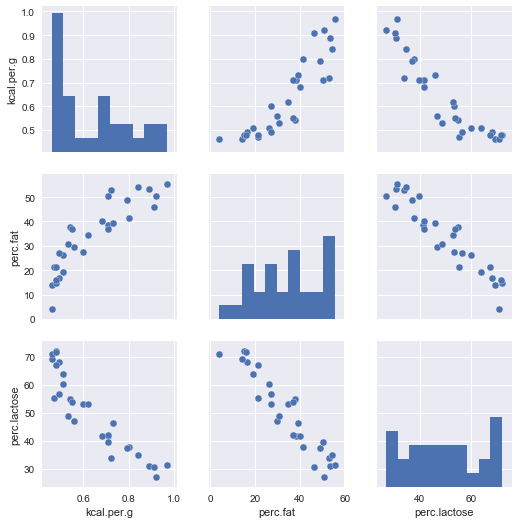

In [44]:
data = d[["kcal.per.g", "perc.fat", "perc.lactose"]]
sns.pairplot(data);

### 5.39

In [45]:
d.corr()["perc.fat"]["perc.lactose"]

-0.9416373456839282

### 5.40

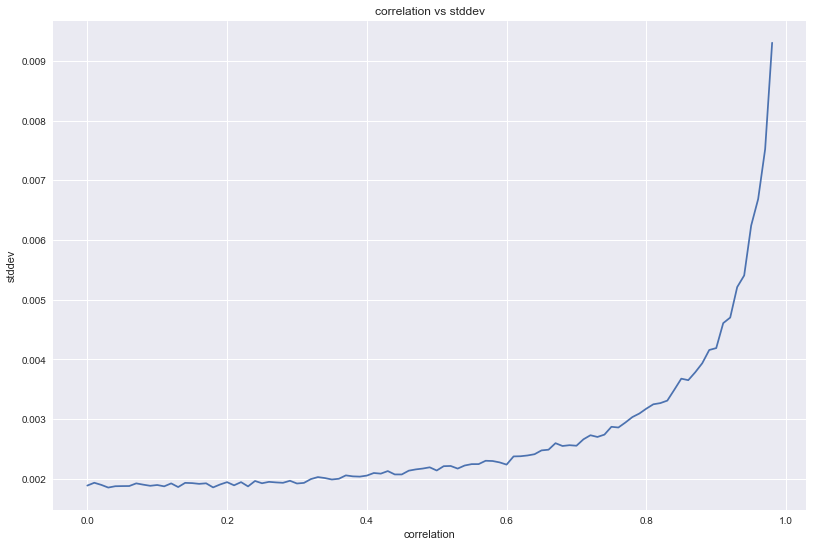

In [46]:
d = pd.read_csv('Data/milk.csv', sep=';')

def sim_coll(r=0.9):
    d['x'] = stats.norm.rvs(size=len(d), 
                            loc = r * d['perc.fat'],
                            scale = np.sqrt((1 - r**2) * d['perc.fat'].var()))
    m = smf.OLS(d['kcal.per.g'], d[["perc.fat", "x"]]).fit()
    cov = m.cov_params()
    return (np.diag(cov)[1])**0.5
    
def rep_sim_coll(r=0.9, n=100):
    stddev = [sim_coll(r) for _ in range(n)]
    return np.mean(stddev)

r_seq = np.arange(0, 0.99, 0.01)
stddev = [rep_sim_coll(r=z, n=100) for z in r_seq]


f, ax = plt.subplots(1, 1)
f.set_size_inches(13.5, 9)

ax.plot(r_seq, stddev)
ax.set_title("correlation vs stddev")
ax.set_xlabel("correlation")
ax.set_ylabel("stddev");

### 5.41

In [47]:
# Number of Plants
N = 100

# simulate initial heights
h0 = stats.norm.rvs(10, 2, N)

# assign treatments and simulate fungus and growth
treatment = np.repeat([0, 1], [N/2]*2)
fungus = stats.binom.rvs(1, 0.5 - treatment*0.4)
h1 = h0 + stats.norm.rvs(5-3*fungus)

# compose a clean data frame
d = pd.DataFrame({"h0": h0,
                  "h1": h1,
                  "treatment": treatment,
                  "fungus": fungus})

### 5.42

In [48]:
with pm.Model() as m5_13:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bf = pm.Normal("bf", mu=0, sd=10)
    bt = pm.Normal("bt", mu=0, sd=10)
    bh = pm.Normal("bh", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bh*d["h0"] + bt*d["treatment"] + bf*d["fungus"])
    h1 = pm.Normal("h1", mu=mu, sd=sigma, observed=d["h1"])
    trace_5_13 = pm.sample(int(1e4), tune=1000)
    
pm.summary(trace_5_13, varnames=["a", "bh", "bt", "bf", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bh, bt, bf, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [01:01<00:00, 359.70draws/s]


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,5.106484,0.534337,0.005652,4.258196,5.967720,9247.526099,0.999993
bh,0.972059,0.052002,0.000543,0.888675,1.054505,9312.774286,0.999953
bt,0.008032,0.221123,0.002081,-0.336788,0.372801,12777.109268,1.000039
bf,-2.847725,0.249367,0.002135,-3.264174,-2.471154,13337.814528,0.999975
sigma,0.965150,0.071408,0.000576,0.845807,1.070123,13880.550259,0.999980


### 5.43

In [49]:
with pm.Model() as m5_14:
    sigma = pm.Uniform("sigma", lower=0, upper=10)
    bt = pm.Normal("bt", mu=0, sd=10)
    bh = pm.Normal("bh", mu=0, sd=10)
    a = pm.Normal("a", mu=0, sd=100)
    mu = pm.Deterministic("mu", a + bh*d["h0"] + bt*d["treatment"])
    h1 = pm.Normal("h1", mu=mu, sd=sigma, observed=d["h1"])
    trace_5_14 = pm.sample(int(1e4), tune=1000)
    
pm.summary(trace_5_14, varnames=["a", "bh", "bt", "sigma"], alpha=0.11)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bh, bt, sigma]
Sampling 2 chains: 100%|██████████| 22000/22000 [00:53<00:00, 414.17draws/s]
The acceptance probability does not match the target. It is 0.8892344440925684, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,mc_error,hpd_5.5,hpd_94.5,n_eff,Rhat
a,4.434614,0.816331,0.008822,3.183743,5.803187,7365.232003,0.999950
bh,0.896287,0.079081,0.000839,0.771158,1.024136,7471.947192,0.999958
bt,1.271720,0.298013,0.002384,0.798883,1.744852,13161.200491,1.000114
sigma,1.489982,0.108501,0.000840,1.316079,1.657016,13675.213930,0.999957
